In [ ]:
#Program to classify steve jobs and zukerbergs images using spark-dl lib
#$ cat jupyter.sh
#function dlnotebook()
#{
#export PYSPARK_PYTHON=python3
#export PYSPARK_DRIVER_PYTHON=/hadoop/softwares/anaconda3/bin/jupyter
#export PYSPARK_DRIVER_PYTHON_OPTS="notebook --no-browser --ip=190.165.0.102"
#$SPARK_HOME/bin/pyspark --packages databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11
#}
#dlnotebook
#####################################
#for input data set 
#curl -O https://github.com/zsellami/images_classification/blob/master/personalities.zip
#unzip personalities.zip
#hdfs dfs -put personalities /tmp
#######################################################################################

In [10]:
import sys
import pyspark
from pyspark.sql import SparkSession,HiveContext
from pyspark import SparkConf,SparkContext
from pyspark.sql.functions import *
import sparkdl as dl
from keras.applications import InceptionV3

In [11]:
spark = SparkSession.builder\
.master("yarn") \
.appName("ImageClassification") \
.config("spark.executor.memory", "16gb") \
.config("spark.driver.memory", "16G") \
.config("spark.driver.offHeap.enabled", "true") \
.config("spark.driver.offHeap.size", "32G") \
.config("spark.executor.maxResultSize", "16gb") \
.config("spark.sql.broadcastTimeout","360000") \
.getOrCreate()
   

In [12]:
img_dir = "/tmp/personalities/"

#Read images and Create training & test DataFrames for transfer learning
from pyspark.ml.image import ImageSchema
jobs_df =  ImageSchema.readImages(img_dir + "/jobs").withColumn("label", lit(0))
zuckerberg_df =  ImageSchema.readImages(img_dir + "/zuckerberg").withColumn("label", lit(1))
jobs_train, jobs_test = jobs_df.randomSplit([0.8, 0.2])
zuckerberg_train, zuckerberg_test = zuckerberg_df.randomSplit([0.8, 0.2])

#dataframe for training a classification model
trainDF = jobs_train.unionAll(zuckerberg_train)
#dataframe for testing the classification model
testDF = jobs_test.unionAll(zuckerberg_test)

In [13]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
def getFilter(fltr):
    if(fltr == 'lr'):
        return LogisticRegression(maxIter=20, regParam=0.05, elasticNetParam=0.3, labelCol="label",featuresCol="features") 
    elif(fltr == 'gbt'):
        return GBTClassifier(maxIter=10)
    elif(fltr == 'dt'):
        return DecisionTreeClassifier(labelCol = "label", featuresCol="features", maxDepth = 3)
    elif(fltr == 'rf'):
        return RandomForestClassifier(labelCol = "label", featuresCol="features")

In [43]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from sparkdl import DeepImageFeaturizer
models=['InceptionV3','Xception','ResNet50','VGG16','VGG19']
filters=['lr','gbt','dt','rf']
featurizer = DeepImageFeaturizer(inputCol="image", outputCol="features", modelName=models[0])
#lr = LogisticRegression(maxIter=20, regParam=0.05, elasticNetParam=0.3, labelCol="label",featuresCol="features")  
def applyFilter(fl):
    p = Pipeline(stages=[featurizer, getFilter(fl)])
    model = p.fit(trainDF)    # train_images_df is a dataset of images and labels
    # Inspect training error
    df = model.transform(testDF)
    predictionAndLabels = df.select("prediction", "label")
    evaluator = MulticlassClassificationEvaluator()
    print("Accuracy : ", evaluator.evaluate(predictionAndLabels,{evaluator.metricName:'accuracy'}))
    print('F1-Score : ', evaluator.evaluate(predictionAndLabels,{evaluator.metricName:'f1'}))
    print('Precision: ', evaluator.evaluate(predictionAndLabels,{evaluator.metricName:'weightedPrecision'}))
    print('Recall   : ', evaluator.evaluate(predictionAndLabels,{evaluator.metricName:'weightedRecall'}))
    #print('areaUnderROC: ', evaluator.evaluate(predictionAndLabels,{evaluator.metricName:'areaUnderROC'}))
#Saving model    
def saveModel(model):
    model.stages[1].write().overwrite().save('/tmp/{}'.format(model))    
for fls in filters:
    applyFilter(fls)

Accuracy :  0.6666666666666666
F1-Score :  0.625
Precision:  0.8
Recall   :  0.6666666666666666
Accuracy :  1.0
F1-Score :  1.0
Precision:  1.0
Recall   :  1.0
Accuracy :  1.0
F1-Score :  1.0
Precision:  1.0
Recall   :  1.0
Accuracy :  0.3333333333333333
F1-Score :  0.3333333333333333
Precision:  0.3333333333333333
Recall   :  0.3333333333333333


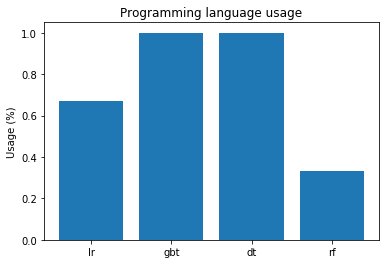

In [23]:
import matplotlib.pyplot as plt
labels = ['lr','gbt','dt','rf']
usage = [0.67, 1.0, 1.0, 0.33]
%matplotlib inline
# Generating the y positions. Later, we'll use them to replace them with labels.
y_positions = range(len(labels))

# Creating our bar plot
plt.bar(y_positions, usage)
plt.xticks(y_positions, labels)
plt.ylabel("Usage (%)")
plt.title("Programming language usage")
plt.show()

/hadoop/softwares/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


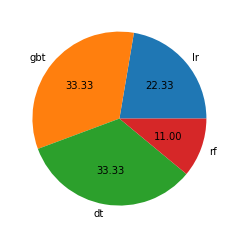

In [24]:
import matplotlib.pyplot as plt
#labels = ['lr','gbt','dt','rf']
#usage = [0.67, 1.0, 1.0, 0.33]
%matplotlib inline
plt.pie(usage, labels = labels, autopct = "%.2f")
plt.axes().set_aspect("equal")
plt.show()

In [22]:
import matplotlib.pyplot as plt

import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.GnBu):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
from sklearn.metrics import confusion_matrix
y_true = df.select("label")
y_true = y_true.toPandas()
y_pred = df.select("prediction")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred,labels=range(2))

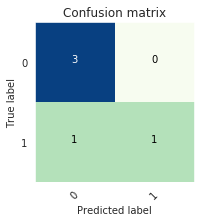

In [15]:
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
plt.figure(figsize=(3,3)) #FIGSIZE(7,7)
plt.grid(False)
# call pre defined function
plot_confusion_matrix(cnf_matrix, classes=range(2))

In [17]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(2)] #range(10)
print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.75      1.00      0.86         3
     Class 1       1.00      0.50      0.67         2

   micro avg       0.80      0.80      0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5



In [18]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
print('ROC AUC score:', multiclass_roc_auc_score(y_true,y_pred))

ROC AUC score: 0.75


In [21]:
print(df.columns)
# see some predicted output
df.select('image', "prediction", "label").show()

['image', 'label', 'features', 'rawPrediction', 'probability', 'prediction']
+--------------------+----------+-----+
|               image|prediction|label|
+--------------------+----------+-----+
|[hdfs://Namenode:...|       0.0|    0|
|[hdfs://Namenode:...|       0.0|    0|
|[hdfs://Namenode:...|       0.0|    0|
|[hdfs://Namenode:...|       0.0|    1|
|[hdfs://Namenode:...|       1.0|    1|
+--------------------+----------+-----+



In [37]:
prediction= predictionAndLabels
from pyspark.ml.evaluation import BinaryClassificationEvaluator
binaryevaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
binary_rate = binaryevaluator.evaluate(prediction)*100
print("accuracy: {}%" .format(binary_rate))

accuracy: 70.0%
